# Example II

This experiment how to model coexisting phenomena

In [31]:
import network_diffusion as nd

from tqdm import tqdm
from utils import helpers, sir_ua_model, networks

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define parameters

In [32]:
# for the model
ALPHA = 0.19
ALPHA_PRIME = 0.35 * ALPHA
BETA = 0.10
GAMMA = 0.01
DELTA = GAMMA + 1 - 0.3

# for the simulation
N_EPOCHS = 60
N_REPETITIONS = 10

### Load the network

In [33]:
net, name = networks.get_aucs_network(file_path="networks/aucs.mpx"), "sir_ua_aucs"
print(net)

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 60
	number of nodes: 120
	number of edges: 317

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 193
	average degree - 6.4333
	clustering coefficient - 0.6733

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 124
	average degree - 4.1333
	clustering coefficient - 0.2882


### Load the model

In [34]:
model = sir_ua_model.SIR_UAModel(
    alpha=ALPHA,
    alpha_prime=ALPHA_PRIME,
    beta=BETA,
    gamma=GAMMA,
    delta=DELTA,
    ill_seeds=5,
    aware_seeds=5,
)
print(model)

SIR-UA Model
compartmental model
--------------------------------------------
processes, their states and initial sizes:
	'contagion': [S:95%, I:5%, R:0%]
	'awareness': [U:95%, A:5%]
--------------------------------------------
process 'contagion' transitions with nonzero weight:
	from S to I with probability 0.19 and constrains ['awareness.U']
	from I to R with probability 0.1 and constrains ['awareness.U']
	from S to I with probability 0.06649999999999999 and constrains ['awareness.A']
	from I to R with probability 0.1 and constrains ['awareness.A']
--------------------------------------------
process 'awareness' transitions with nonzero weight:
	from U to A with probability 0.01 and constrains ['contagion.S']
	from U to A with probability 0.71 and constrains ['contagion.I']
	from U to A with probability 0.01 and constrains ['contagion.R']
seed selection method
--------------------------------------------
	nodewise random choice



### Perform the simulation

In [35]:
all_logs = []
for i in tqdm(range(N_REPETITIONS)):
    experiment = nd.Simulator(model, net.copy())
    run_logs = experiment.perform_propagation(n_epochs=N_EPOCHS)
    all_logs.append(run_logs)

100%|██████████| 10/10 [00:00<00:00, 10.14it/s]


### Convert the logs and plot the results

In [36]:
mean_curve, std_curve = helpers.aggregate_results(all_logs)

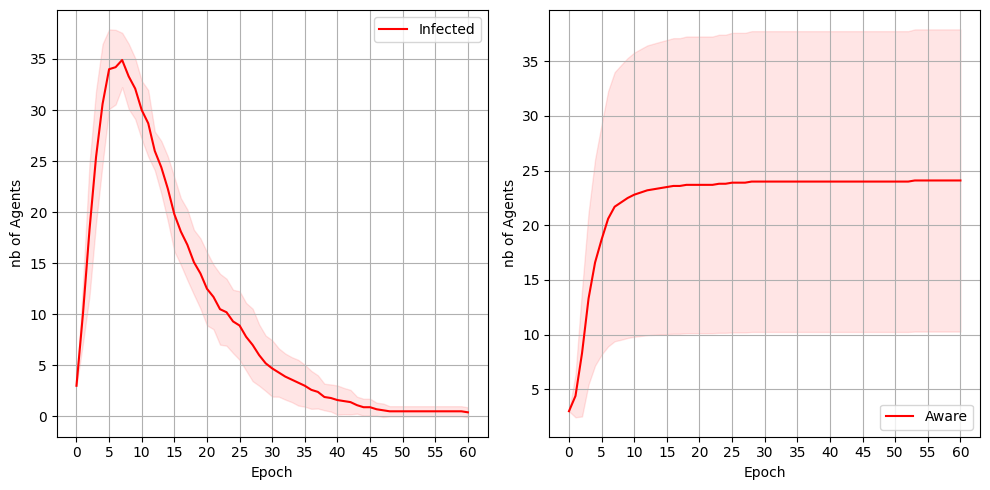

In [37]:
helpers.visualise_spread(mean_curve, std_curve)

In [38]:
run_logs.get_detailed_logs()

{0: [{'layer_name': 'contagion', 'node_name': 'U4', 'new_state': 'I'},
  {'layer_name': 'contagion', 'node_name': 'U138', 'new_state': 'I'},
  {'layer_name': 'contagion', 'node_name': 'U123', 'new_state': 'I'},
  {'layer_name': 'contagion', 'node_name': 'U41', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U118', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U91', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U48', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U14', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U17', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U59', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U29', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U68', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U112', 'new_state': 'S'},
  {'layer_name': 'contagion', 'node_name': 'U19', 'new_state': 'S'},
  {'layer_name': 'contagion'

In [39]:
run_logs.get_aggragated_logs()

[{'contagion': (('S', 57), ('I', 3)), 'awareness': (('U', 57), ('A', 3))},
 {'contagion': (('S', 47), ('I', 13)), 'awareness': (('U', 51), ('A', 9))},
 {'contagion': (('S', 31), ('I', 29)), 'awareness': (('U', 41), ('A', 19))},
 {'contagion': (('S', 26), ('R', 3), ('I', 31)),
  'awareness': (('U', 35), ('A', 25))},
 {'contagion': (('S', 22), ('R', 4), ('I', 34)),
  'awareness': (('A', 28), ('U', 32))},
 {'contagion': (('S', 15), ('R', 8), ('I', 37)),
  'awareness': (('A', 29), ('U', 31))},
 {'contagion': (('S', 11), ('R', 13), ('I', 36)),
  'awareness': (('A', 31), ('U', 29))},
 {'contagion': (('S', 10), ('R', 14), ('I', 36)),
  'awareness': (('A', 31), ('U', 29))},
 {'contagion': (('S', 10), ('R', 22), ('I', 28)),
  'awareness': (('A', 31), ('U', 29))},
 {'contagion': (('S', 8), ('R', 23), ('I', 29)),
  'awareness': (('A', 32), ('U', 28))},
 {'contagion': (('S', 7), ('R', 24), ('I', 29)),
  'awareness': (('A', 32), ('U', 28))},
 {'contagion': (('S', 5), ('R', 27), ('I', 28)),
  'aware

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 60
	number of nodes: 120
	number of edges: 317

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 193
	average degree - 6.4333
	clustering coefficient - 0.6733

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 124
	average degree - 4.1333
	clustering coefficient - 0.2882
SIR-UA Model
compartmental model
--------------------------------------------
processes, their states and initial sizes:
	'contagion': [S:95%, I:5%, R:0%]
	'awareness': [U:95%, A:5%]
--------------------------------------------
process 'contagion' transitions with nonzero weight:
	from S to I with probability 0.19 and constrains ['awareness.U']
	from I to R with probability 0.1 and constrains ['awareness.U']
	from S to I with probability 0.06649999999

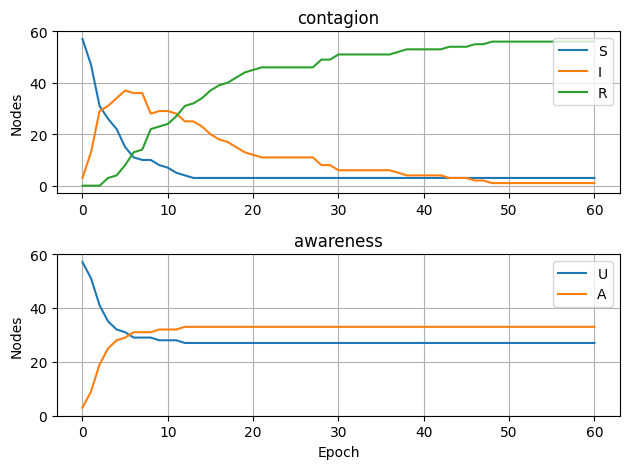

In [40]:
run_logs.report(visualisation=True)